In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc  # For garbage collection to free memory
import os
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

tf.keras.backend.clear_session()

# Paths to dataset
image_dir_1 = '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1'
image_dir_2 = '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2'
metadata_file = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'

# Load metadata
labels = pd.read_csv(metadata_file)

# Resize to a smaller size (64x64) to save memory
IMG_SIZE = 64

# Data Generators
def load_and_preprocess_data(labels, image_dir_1, image_dir_2, img_size):
    images = []
    label_list = []

    for _, row in labels.iterrows():
        file_path_1 = os.path.join(image_dir_1, row['image_id'] + '.jpg')
        file_path_2 = os.path.join(image_dir_2, row['image_id'] + '.jpg')

        if os.path.exists(file_path_1):
            img = Image.open(file_path_1).resize((img_size, img_size))  # Resize to img_size x img_size
        elif os.path.exists(file_path_2):
            img = Image.open(file_path_2).resize((img_size, img_size))
        else:
            continue  # Skip if file is missing

        images.append(np.array(img) / 255.0)  # Normalize to [0, 1]
        label_list.append(row['dx'])  # Append diagnosis

    X = np.array(images)  # Shape: (num_samples, img_size, img_size, 3)
    y = pd.factorize(pd.Series(label_list))[0]  # Encode labels as integers
    y_one_hot = to_categorical(y)  # Convert labels to one-hot encoding
    class_names = pd.factorize(pd.Series(label_list))[1]  # Class names for reference
    return X, y_one_hot, class_names

# Call the function to load data
X, y_one_hot, class_names = load_and_preprocess_data(labels, image_dir_1, image_dir_2, IMG_SIZE)

# Check memory usage
print(f"Dataset size (in memory): {X.nbytes / (1024 ** 2):.2f} MB")

# Split into training and validation sets (e.g., 80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Free memory
del X, y_one_hot
gc.collect()

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

# Data augmentation for memory-efficient loading
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator()

# Train and validation generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=16)
val_generator = val_datagen.flow(X_val, y_val, batch_size=16)

print("Data generators created successfully.")

# Save directory for outputs
save_dir = '/kaggle/working/gan_outputs/'
os.makedirs(save_dir, exist_ok=True)
print(f"All outputs will be saved in: {save_dir}")


Dataset size (in memory): 938.91 MB
Training set shape: (8012, 64, 64, 3)
Validation set shape: (2003, 64, 64, 3)
Data generators created successfully.
All outputs will be saved in: /kaggle/working/gan_outputs/


In [2]:
from tensorflow.keras import mixed_precision

# Set the mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print(f"Mixed precision policy set to: {policy}")


Mixed precision policy set to: <FloatDTypePolicy "mixed_float16">


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
import gc
import tensorflow as tf
gc.collect()
tf.keras.backend.clear_session()

In [5]:
from tensorflow.keras import layers, models
import tensorflow as tf

latent_dim = 128

# Encoder
encoder = models.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Flatten(),
    layers.Dense(latent_dim)  # Latent representation
])

# Decoder
decoder = models.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(8 * 8 * 512),
    layers.Reshape((8, 8, 512)),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(3, kernel_size=4, padding="same", activation="tanh"),
])

# Full autoencoder model
autoencoder = models.Sequential([
    layers.Input(shape=(64,64,3)),
    encoder,
    decoder
])

# Generator is just the decoder part (it takes latent vector as input)
def build_generator(latent_dim):
    return decoder

# Discriminator
def build_discriminator(img_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=img_shape))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Compile GAN
def compile_gan(generator, discriminator, latent_dim):
    # Compile the discriminator independently
    discriminator.trainable = True
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

    # Freeze the discriminator when training the GAN
    discriminator.trainable = False

    # Create GAN model
    gan_input = layers.Input(shape=(latent_dim,))  # Latent vector input
    fake_img = generator(gan_input)  # Generator takes latent vector and produces image
    gan_output = discriminator(fake_img)  # Discriminator evaluates the generated image
    gan = models.Model(gan_input, gan_output)

    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

    return generator, discriminator, gan

# Build and compile
generator = build_generator(latent_dim)
discriminator = build_discriminator((64, 64, 3))
generator, discriminator, gan = compile_gan(generator, discriminator, latent_dim)

# Output the shapes of the models
print("Generator Summary:")
generator.summary()
print("\nDiscriminator Summary:")
discriminator.summary()


Generator Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 32768)          │     4,227,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,983,107 (26.64 MB)

 Trainable params: 6,983,107 (26.64 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    12,583,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,240,321 (50.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13,240,321 (50.51 MB)

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Compile Discriminator (binary crossentropy loss and Adam optimizer)
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

# Compile GAN model (combined model) with the discriminator frozen
discriminator.trainable = False
gan_input = layers.Input(shape=(latent_dim,))
fake_img = generator(gan_input)
gan_output = discriminator(fake_img)
gan = models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1734112353.172129      70 service.cc:145] XLA service 0x7e96a40015d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734112353.172184      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734112353.172188      70 service.cc:153]   StreamExecutor device (1): Tesla 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1734112355.107182      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

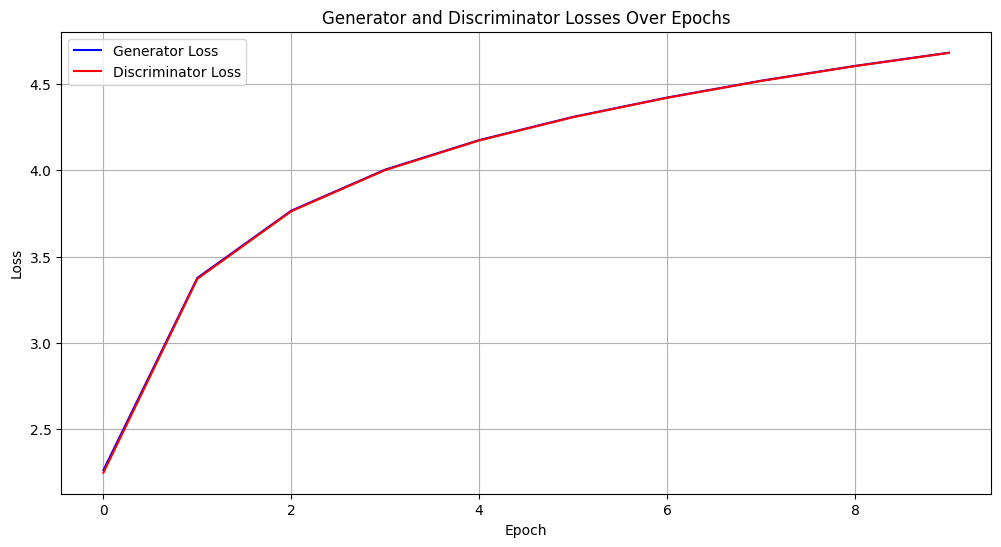

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import os
import matplotlib.pyplot as plt

# Define constants
latent_dim = 128  # Latent dimension for generator input
output_dir = "gan_model"  # Directory to save models
os.makedirs(output_dir, exist_ok=True)

# Initialize loss lists before training
generator_losses = []
discriminator_losses = []

# Define the generator
def build_generator(latent_dim):
    model = keras.Sequential([
        layers.Dense(8 * 8 * 512, activation="relu", input_dim=latent_dim),
        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(3, kernel_size=3, activation="tanh", padding="same")
    ])
    return model

# Define the discriminator
def build_discriminator(img_shape):
    model = keras.Sequential([
        layers.Flatten(input_shape=img_shape),
        layers.Dense(1024, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

# Build models
generator = build_generator(latent_dim)
discriminator = build_discriminator((64, 64, 3))

# Compile the discriminator
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    metrics=["accuracy"]
)

# Compile the GAN model
discriminator.trainable = False
gan_input = layers.Input(shape=(latent_dim,))
fake_img = generator(gan_input)
gan_output = discriminator(fake_img)
gan = models.Model(gan_input, gan_output)
gan.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

# Training function
def train_gan(generator, discriminator, gan, train_data, latent_dim, epochs=10, batch_size=8):
    for epoch in range(epochs):
        epoch_d_loss = []  # To track the discriminator loss for each batch in this epoch
        epoch_g_loss = []  # To track the generator loss for each batch in this epoch

        for _ in range(len(train_data) // batch_size):
            # Generate random noise and fake images
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            fake_images = generator.predict(noise)

            # Select a random batch of real images
            idx = np.random.randint(0, train_data.shape[0], batch_size)
            real_images = train_data[idx]

            # Create labels for real (1) and fake (0) images
            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])  # Assuming loss is the first item

            # Train the generator via the GAN model
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, real_labels)

            # Append losses for this batch
            epoch_d_loss.append(d_loss)
            epoch_g_loss.append(g_loss[0])

        # Average losses for the epoch
        discriminator_losses.append(np.mean(epoch_d_loss))
        generator_losses.append(np.mean(epoch_g_loss))

        # Save model weights after each epoch
        if (epoch + 1) % 5 == 0:  # Save models every 5 epochs
            generator.save(f"{output_dir}/generator_epoch_{epoch + 1}.h5")
            discriminator.save(f"{output_dir}/discriminator_epoch_{epoch + 1}.h5")
        print(f"Epoch {epoch + 1}/{epochs} completed.")

# Load or create training data (example with random data)
train_data = np.random.random((1000, 64, 64, 3)) * 2 - 1  # Example dataset with random noise

# Train the GAN
train_gan(generator, discriminator, gan, train_data, latent_dim, epochs=10, batch_size=8)

# Plot the losses for the generator and discriminator after training
plt.figure(figsize=(12, 6))

# Plot generator loss
plt.plot(generator_losses, label="Generator Loss", color="blue")

# Plot discriminator loss
plt.plot(discriminator_losses, label="Discriminator Loss", color="red")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


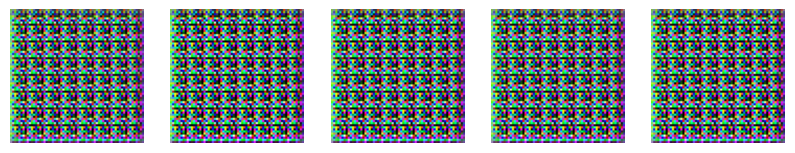

In [8]:
import matplotlib.pyplot as plt

# Generate random noise to create fake images
noise = np.random.normal(0, 1, (5, latent_dim))  # Generate 5 images
fake_images = generator.predict(noise)

# Plot the generated images
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow((fake_images[i] + 1) / 2)  # Rescale images from [-1, 1] to [0, 1]
    plt.axis('off')
plt.show()


In [9]:
# Select a random batch of real images and fake images
idx = np.random.randint(0, train_data.shape[0], 10)
real_images = train_data[idx]
fake_images = generator.predict(np.random.normal(0, 1, (10, latent_dim)))

# Evaluate the discriminator on real and fake images
real_preds = discriminator.predict(real_images)
fake_preds = discriminator.predict(fake_images)

print("Real images discriminator predictions:", real_preds)
print("Fake images discriminator predictions:", fake_preds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Real images discriminator predictions: [[0.6379103 ]
 [0.5725856 ]
 [0.5602418 ]
 [0.36231318]
 [0.60450846]
 [0.43991163]
 [0.43614677]
 [0.631575  ]
 [0.3601478 ]
 [0.40186024]]
Fake images discriminator predictions: [[0.999962  ]
 [0.9999585 ]
 [0.9999548 ]
 [0.9999641 ]
 [0.9999602 ]
 [0.99995875]
 [0.99995816]
 [0.9999628 ]
 [0.99995863]
 [0.99995565]]


In [10]:
generator.save(f"{output_dir}/generator_final.h5")
discriminator.save(f"{output_dir}/discriminator_final.h5")
print("Final models saved.")


Final models saved.


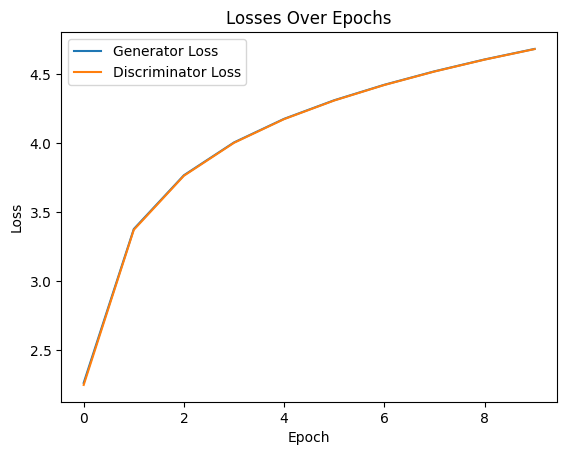

In [11]:
# Assuming you have lists for losses (this would need to be updated during training)
plt.plot(generator_losses, label="Generator Loss")
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses Over Epochs")
plt.legend()
plt.show()
